[Hands-On Reinforcement Learning Course: Part 2 - Tabular Q Learning](https://towardsdatascience.com/hands-on-reinforcement-learning-course-part-2-1b0828a1046b)

by [Pau Labarta Bajo](https://pau-labarta-bajo.medium.com/?source=post_page-----269b50e39d08--------------------------------), Dec 7, 2021.  [[github repo for this lesson]](https://github.com/Paulescu/hands-on-rl)

Summarized and Revised by Ivan H.P. Lin

All the code for this lesson is in [this Github repo](https://github.com/Paulescu/hands-on-rl). Git clone it to follow along with today’s problem.

<img src="https://miro.medium.com/max/1050/1*Aef4_9CUysYfv18dulK5uw.jpeg" width="50%">

# 0. Contents

1. The taxi driving problem 🚕
2. Environment, actions, states, rewards
3. Random agent baseline 🤖🍷
4. Q-learning agent 🤖🧠
5. Hyper-parameter tuning 🎛️
6. Recap ✨
7. Homework 📚
8. What’s next? ❤️

#1.. The taxi driving problem 🚕
We will teach an agent to drive a taxi using Reinforcement Learning.

Driving a taxi in the real world is a very complex task to start with. Because of this, we will work in a simplified environment that captures the 3 essential things a good taxi driver does, which are:

* pick up passengers and drop them at their desired destination.
* drive safely, meaning no crashes.
* drive them in the shortest time possible.
We will use an environment from **[OpenAI Gym](https://gym.openai.com/)**, called the **[Taxi-v3](https://gym.openai.com/envs/Taxi-v3/)** environment.

<figure><center>
<img src="https://miro.medium.com/max/1050/1*toX5ZWcYxXtsaXE6hQJ1ag.png" width="70%">
<figcaption>Taxi environment (Image by the author)</figcaption>
</figure></center>


There are four designated locations in the grid world indicated by **R(ed)**, **G(reen)**, **Y(ellow)**, and **B(lue)**.

When the episode starts, the taxi starts off at a random square and the passenger is at a random location **(R, G, Y or B)**.

The taxi drives to the passenger’s location, picks up the passenger, drives to the passenger’s destination (another one of the four specified locations), and then drops off the passenger. While doing so, our taxi driver needs to drive carefully to avoid hitting any wall, marked as **$|$**. Once the passenger is dropped off, the episode ends.

[![Good taxi driver](https://www.gocoder.one/static/taxi-states-0aad1b011cf3fe07b571712f2123335c.png)](https://youtu.be/eqod3gNoVgU "q agent in the Taxi-v3 environment")



# 2.. **Environment**, **Actions**, **States**, **Rewards** 👉🏽 
[notebooks/00_environment.ipynb](https://github.com/Paulescu/hands-on-rl/blob/main/01_taxi/notebooks/00_environment.ipynb)

👉Before you solve a Reinforcement Learning problem you need to define what are
* the actions
* the states of the world
* the rewards

👉We are using the Taxi-v3 environment from [OpenAI's gym - Taxi-v3](https://gym.openai.com/envs/Taxi-v3/)
  - 👉Taxi-v3 is an easy environment because the action space is small, and the state space is large but finite.
  - 👉Environments with a finite number of actions and states are called tabular

In [ ]:
%load_ext autoreload
%autoreload 2
%pylab inline
%config InlineBackend.figure_format = 'svg'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['info']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Load the environment 🌎

In [ ]:
import gym
env = gym.make("Taxi-v3").env

## **Action space**
What are the **actions** the agent can choose from at each step?

0. drive down
1. drive up
2. drive right
3. drive left
4. pick up a passenger
5. drop off a passenger

<img src="https://miro.medium.com/max/1050/1*Pzbq6efaMcgpDtLNa80TTw.png" width="50%">

In [ ]:
print("Action Space {}".format(env.action_space))


Action Space Discrete(6)


## **State space**

* 25 possible taxi positions, because the world is a 5x5 grid.
* 5 possible locations of the passenger, which are R, G, Y, B, plus the case when the passenger is in the taxi.
* 4 destination locations

Which gives us 25 x 5 x 4 = 500 states

<img src="https://miro.medium.com/max/1050/1*OJtU-V4bz8PmY4s5G6NDIw.png" width="50%">

In [ ]:
print("State Space {}".format(env.observation_space))

State Space Discrete(500)


## **Rewards**

* -1 default per-step reward.
  - Why -1, and not simply 0? 
  - Because we want to encourage the agent to spend the shortest time, by penalizing each extra step. This is what you expect from a taxi driver, don’t you?
* +20 reward for delivering the passenger to the correct destination.
* -10 reward for executing a pickup or dropoff at the wrong location.

You can read the rewards and the environment transitions $(state, action) \rightarrow next\_state$ from ```env.P```.

In [ ]:
# env.P is double dictionary.
# - The 1st key represents the state, from 0 to 499
# - The 2nd key represens the action taken by the agent,
#   from 0 to 5

# example
state = 123
action = 0  # move south

# env.P[state][action][0] is a list with 4 elements
# (probability, next_state, reward, done)
# 
#  - probability
#    It is always 1 in this environment, which means
#    there are no external/random factors that determine the
#    next_state
#    apart from the agent's action a.
#
#  - next_state: 223 in this case
# 
#  - reward: -1 in this case
#
#  - done: boolean (True/False) indicates wheter the
#    episode has ended (i.e. the driver has dropped the
#    passenger at the correct destination)
print('env.P[state][action][0]: ', env.P[state][action][0])

env.P[state][action][0]:  (1.0, 223, -1, False)


By the way, you can render the environment under each state to double-check this ```env.P``` vectors make sense:

* From ```state=123```
<figure><center>
<img src="https://miro.medium.com/max/1050/1*emheFKcptnVD2KrM7DrQ1g.png" width="40%">
<figcaption>$state=123$</figcaption>
</center></figure>

* The agent moves south $action=0$ to get to $state=223$
<figure><center>
<img src="https://miro.medium.com/max/1050/1*t9urLESKVNKcwBKqWxmmlA.png" width="40%">
<figcaption>$state=223$</figcaption>
</center></figure>

And the reward is $-1$, as neither the episode ended, nor the driver incorrectly picked or dropped.

In [ ]:
# Need to call reset() at least once before render() will work
env.reset()

env.s = 123
env.render(mode='human')
print('env.P[state][action][0]: ', env.P[state][action][0])

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

env.P[state][action][0]:  (1.0, 223, -1, False)


In [ ]:
env.s = 223
env.render(mode='human')
print('env.P[state][action][0]: ', env.P[state][action][0])

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

env.P[state][action][0]:  (1.0, 223, -1, False)


# 3.. **Random agent baseline** 🤖🍷 👉🏽 
[01_random_agent_baseline.ipynb](https://github.com/Paulescu/hands-on-rl/blob/main/01_taxi/notebooks/01_random_agent_baseline.ipynb)

Before you start implementing any complex algorithm, you should always build a baseline model.

This advice applies not only to Reinforcement Learning problems but Machine Learning problems in general.

It is very tempting to jump straight into the complex/fancy algorithms, but unless you are really experienced, you will fail terribly.

Let’s use a random agent 🤖🍷 as a baseline model.
* 👉Before you try to solve a Reinforcement Learning problem you should get a grasp of its difficulty.
* 👉 To do so, you need to design a dummy agent that can peform the task without much brains, and evaluate its performance.
* 👉A simple way to do so is by using a Random Agent, that chooses its next action randomly, without paying attention at the current state of the environment.
* 👉Needless to say, do not grab a taxi driven by a Random Driver.

### Load the Environment 🌎

In [ ]:
%load_ext autoreload
%autoreload 2
%pylab inline
%config InlineBackend.figure_format = 'svg'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


In [ ]:
import gym
env = gym.make("Taxi-v3").env

<img src="https://miro.medium.com/max/1050/1*6I9oN8TQ6-cETliGzCo-yg.png" width="40%">

In [ ]:
class RandomAgent:
    """
    This taxi driver selects actions randomly.
    You better not get into this taxi!
    """
    def __init__(self, env):
        self.env = env

    def get_action(self, state) -> int:
        """
        We have `state` as an input to keep
        a consistent API for all our agents, but it
        is not used.
        
        i.e. The agent does not consider the state of
        the environment when deciding what to do next.
        This is why we call it "random".
        """
        return self.env.action_space.sample()

agent = RandomAgent(env)

## **Random agent 🤖🍷**

### evaluate this driver starting from a fixed ```state = 123```

In [ ]:
# set initial state of the environment
env.reset()
state = 123
env.s = state

epochs = 0
penalties = 0  # wrong pick up or dropp off
reward = 0

# store frames to latter plot them
frames = []

done = False

while not done:
    
    action = agent.get_action(state)
    
    state, reward, done, info = env.step(action)

    if reward == -10:
        penalties += 1
    
    frames.append({
        'frame': env.render(mode='ansi'),
        'state': state,
        'action': action,
        'reward': reward
        }
    )

    epochs += 1
    
    
print("Timesteps taken: {}".format(epochs))
print("Penalties incurred: {}".format(penalties))

Timesteps taken: 5201
Penalties incurred: 1706


In [ ]:
from IPython.display import clear_output
from time import sleep

def print_frames(frames):
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        print(frame['frame'])
        print(f"Timestep: {i + 1}/{len(frames)}")
        print(f"State: {frame['state']}")
        print(f"Action: {frame['action']}")
        print(f"Reward: {frame['reward']}")
        sleep(0.01)
        
print_frames(frames)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Timestep: 5201/5201
State: 475
Action: 5
Reward: 20


We can see how this agent performs for a given initial ```state=123```

<img src="https://miro.medium.com/max/1050/1*BhfZjfQ-q4Gnzcl501RUNg.png" width="40%">

[![Random agent in action](https://vitez.me/images/q-learning/taxi.gif)](https://www.youtube.com/watch?v=GExnnTaBELk&feature=emb_rel_end "Random agent in action")



### histograms to quantify performance

To get a more representative measure of performance, we can repeat the same evaluation loop ```n=100``` times starting each time at a random state.

<img src="https://miro.medium.com/max/1050/1*rGG0oYxuUioE-bVIgc2jhg.png" width="40%">



If you plot ```timesteps_per_episode``` and ```penalties_per_episode``` you can observe that none of them decreases as the agent completes more episodes. In other words, the agent is NOT LEARNING anything.

<img src="https://miro.medium.com/max/1050/1*aPZL0OuLh-1XX6RNgwVL0Q.png" width="50%">


If you want summary statistics of performance you can take averages:
<img src="https://miro.medium.com/max/1050/1*G_3Efv821ncbYJUSuNKJAg.png" width="60%">



In [ ]:
from tqdm import tqdm

n_episodes = 100

# For plotting metrics
timesteps_per_episode = []
penalties_per_episode = []

for i in tqdm(range(0, n_episodes)):
    
    # reset environment to a random state
    state = env.reset()

    epochs, penalties, reward, = 0, 0, 0
    done = False
    
    while not done:
        
        action = agent.get_action(state)       
        next_state, reward, done, info = env.step(action) 
               
        if reward == -10:
            penalties += 1

        state = next_state
        epochs += 1
    
    timesteps_per_episode.append(epochs)
    penalties_per_episode.append(penalties)

100%|██████████| 100/100 [00:06<00:00, 16.13it/s]


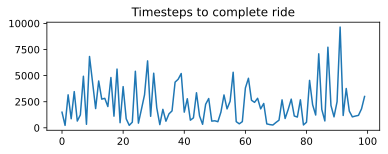

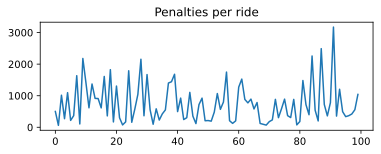

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (6, 2))
ax.set_title("Timesteps to complete ride")    
pd.Series(timesteps_per_episode).plot(kind="line")
plt.show()

fig, ax = plt.subplots(figsize = (6, 2))
ax.set_title("Penalties per ride")    
pd.Series(penalties_per_episode).plot(kind="line")
plt.show()


Let’s implement our first “intelligent” agent using **$Q$-learning**, one of the earliest and most used RL algorithms that exist.

# 4.. **$Q$-learning agent** 🤖🧠 
[02_q_agent.ipynb](https://github.com/Paulescu/hands-on-rl/blob/main/01_taxi/notebooks/02_q_agent.ipynb)

***$Q$-Agent***

* 👉Let's use Q-learning to train a smart taxi driver.

* 👉A smart taxi driver should incur no penalties (i.e. no crashes) and minimize the timesteps to complete the ride.


**$Q$-learning** (by [Chris Walkins](http://www.cs.rhul.ac.uk/~chrisw/)  and [Peter Dayan](https://en.wikipedia.org/wiki/Peter_Dayan)) is an algorithm to find the optimal **$q$-value** function.

As we said in [part 1(colab)](https://colab.research.google.com/drive/1BA6-E6zKS0fWN7enURI_p69VX6iE_Zm_?usp=sharing)/[part 1(datSci)](https://towardsdatascience.com/hands-on-reinforcement-learning-course-part-1-269b50e39d08), the **$q$-value** function $Q(s, a)$ associated with a policy **$\pi$** is:
* The total reward the agent expects to get when at state $s$ the agent takes action $a$ and follows policy $\pi$ thereafter.
* The optimal **$q$-value** function **$Q^* (s, a)$** is the **$q$-value** function associated with the optimal policy **$π^*$**.
* If you know **$Q^*(s, a)$** you can infer $π^*$: 
  - i.e. you pick as the next action the one that maximizes **$Q^*(s, a)$** for the current state **$s$**.

**$Q$-learning** is an iterative algorithm to compute better and better approximations to the optimal **$q$-value** function **$Q^*(s, a)$**, starting from an arbitrary initial guess **$Q^⁰(s, a)$**

$$Q^o(s,a) \rightarrow Q^1(s,a) \rightarrow Q^2(s,a) \rightarrow ⋯ Q^N(s,a) \approx Q^*(s,a)$$


In a tabular environment like ```Taxi-v3``` with a finite number of states and actions, a **$q$-function** is essentially a matrix. It has as many rows as states and columns as actions, i.e. $500$ x $6$ = $3000$.

In [ ]:
%load_ext autoreload
%autoreload 2
%pylab inline
%config InlineBackend.figure_format = 'svg'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


### Environment 🌎

In [ ]:
import gym
env = gym.make("Taxi-v3").env

## **$Q$-agent 🤖🧠**

### From $Q^o(s,a)$ to $Q^1(s,a)$: How to?

How exactly do you compute the next approximation $Q^1(s, a)$ from $Q^o(s, a)$?

the key formula in Q-learning:

<figure><center>
<img src="https://miro.medium.com/max/1050/1*ODDuOVNWybX6g0CI4i2Uiw.png" width="75%">
<figcaption>Q-learning formula (Image by the author)</figcaption>
</center></figure>

As the **$q$-agent** navigates the environment and observes the next state **$s’$** and reward **$r$**, you update your **$q$-value** matrix with this formula.

### **learning rate $\alpha$**

The learning rate (as usual in machine learning) is a small number that controls how large are the updates to the **$q$-function**. You need to tune it, as 
  - too large of a value will cause unstable training, and 
  - too small might not be enough to escape local minima.

### **discount factor $\gamma$**

The discount factor is a (hyper) parameter between 0 and 1 that determines how much our agent cares about **rewards in the distant future relative to those in the immediate future.**

* When **$\gamma = 0$**, the agent only cares about maximizing immediate reward. As it happens in life, maximizing immediate reward is not the best recipe for optimal long-term outcomes. This happens in RL agents too.

* When **$\gamma = 1$**, the agent evaluates each of its actions based on the sum total of all of its future rewards. In this case the agent weights equally immediate rewards and future rewards.

The discount factor is typically an intermediate value, e.g. 0.6.

### summary

To sum up, if you

- train long enough
- with a decent learning rate and discount factor
- the agent explores enough the state space
- update the **$q$-value** matrix with the **$Q$-learning** formula
your initial approximation will eventually converge to optimal **$q$-matrix**. Voila!

Let’s implement a Python class for a Q-agent then.

### python implementation

<figure><center>
<img src="https://miro.medium.com/max/1050/1*QGxq4MhDX3FNCEhmdp6ukQ.png" width="50%">
<figcaption>API for a Q-agent</figcaption>
</center></figure>

In [ ]:
import numpy as np

class QAgent:

    def __init__(self, env, alpha, gamma):
        self.env = env

        # table with q-values: n_states * n_actions
        self.q_table = np.zeros([env.observation_space.n,
                                 env.action_space.n])

        # hyper-parameters
        self.alpha = alpha  # learning rate
        self.gamma = gamma  # discount factor

    def get_action(self, state):
        """"""
        return np.argmax(self.q_table[state])

    def update_parameters(self, state, action, reward, next_state):
        """"""
        # Q-learning formula
        old_value = self.q_table[state, action]
        next_max = np.max(self.q_table[next_state])
        new_value = \
            old_value + \
            self.alpha * (reward + self.gamma * next_max - old_value)

        # update the q_table
        self.q_table[state, action] = new_value

In [ ]:
# hyper-parameters
# RL problems are full of these hyper-parameters.
# For the moment, trust me when I set these values.
# We will later play with these and see how they impact learning.
alpha = 0.1
gamma = 0.6

agent = QAgent(env, alpha, gamma)

## **$Q$-Agent** Training loop 🎡

Its API is the same as for the ```RandomAgent``` above, but with an extra method ```update_parameters()```. This method takes the ***transition vector $(state, action, reward, next\_state)$*** and updates the **$q$-value matrix** approximation ```self.q_table``` using the ***$Q$-learning*** formula from above.

Now, we need to plug this agent into a training loop and call its ```update_parameters()``` method every time the agent collects a new experience.

Also, remember we need to guarantee the agent explores enough the state space. Remember the exploration-exploitation parameter we talked about in [part 1](https://towardsdatascience.com/hands-on-reinforcement-learning-course-part-1-269b50e39d08)? This is when the ```epsilon`` parameter ($ϵ$) enters into the game.

Let’s train the agent for ```n_episodes = 10,000``` and use ```epsilon = 10%``` ($ϵ=0.1$)

<figure><center>
<img src="https://miro.medium.com/max/1050/1*mKmMUC5n_5NDT6WBt6_ivw.png" width="50%">
</center></figure>

In [ ]:
import random
from tqdm import tqdm

# exploration vs exploitation prob
epsilon = 0.1

n_episodes = 10000

# For plotting metrics
timesteps_per_episode = []
penalties_per_episode = []


for i in tqdm(range(0, n_episodes)):
    
    state = env.reset()

    epochs, penalties, reward, = 0, 0, 0
    done = False
    
    while not done:
        
        if random.uniform(0, 1) < epsilon:
            # Explore action space
            action = env.action_space.sample()
        else:
            # Exploit learned values
            action = agent.get_action(state)
        
        next_state, reward, done, info = env.step(action) 
        
        agent.update_parameters(state, action, reward, next_state)
        
        if reward == -10:
            penalties += 1

        state = next_state
        epochs += 1
        
    timesteps_per_episode.append(epochs)
    penalties_per_episode.append(penalties)

100%|██████████| 10000/10000 [00:07<00:00, 1278.67it/s]


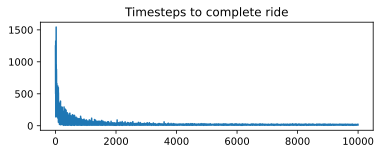

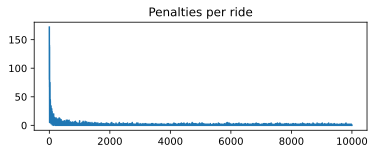

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (6, 2))
ax.set_title("Timesteps to complete ride")    
pd.Series(timesteps_per_episode).plot(kind='line')
plt.show()

fig, ax = plt.subplots(figsize = (6, 2))
ax.set_title("Penalties per ride")    
pd.Series(penalties_per_episode).plot(kind='line')
plt.show()

These graphs look much much better than for the ```RandomAgent```. Both metrics decrease with training, which means our agent is learning 🎉🎉🎉.

We can actually see how the agent drives starting from the same ```state = 123``` as we used for the ```RandomAgent```.

### evaluate this driver from a fixed state = 123

<figure><center>
<img src="https://miro.medium.com/max/1050/1*_MLHTX9OKPc9yxDgZUofMA.png" width="50%">
</center></figure>

In [ ]:
# set initial state of the environment
state = 123
env.s = state

epochs = 0
penalties = 0
reward = 0

# store frames to latter plot them
frames = []

done = False

while not done:
    
    action = agent.get_action(state)
    
    next_state, reward, done, info = env.step(action)
    agent.update_parameters(state, action, reward, next_state)

    if reward == -10:
        penalties += 1
    
    frames.append({
        'frame': env.render(mode='ansi'),
        'state': state,
        'action': action,
        'reward': reward
        }
    )

    state = next_state

    epochs += 1
    
print("Timesteps taken: {}".format(epochs))
print("Penalties incurred: {}".format(penalties))

Timesteps taken: 11
Penalties incurred: 0


In [ ]:
from IPython.display import clear_output
from time import sleep

def print_frames(frames):
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        print(frame['frame'])
        print(f"Timestep: {i + 1} of {len(frames)}")
        print(f"State: {frame['state']}")
        print(f"Action: {frame['action']}")
        print(f"Reward: {frame['reward']}")
        sleep(0.5)
        
print_frames(frames)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Timestep: 11 of 11
State: 479
Action: 5
Reward: 20


If you want to compare hard numbers you can evaluate the performance of the ***$q$-agent*** on, let’s say, 100 random episodes and compute the average number of timestamps and penalties incurred.

### Training agent on 100 episodes, and **episilon-greedy strategy**

When you evaluate the agent, it is still good practice to use a positive epsilon value, and not ```epsilon = 0```.

Why so? Isn’t our agent fully trained? Why do we need to keep this source of randomness when we choose the next action?

The reason is to prevent ***overfitting***. Even for such a small state, action space in ```Taxi-v3```(i.e. 500 x 6) it is likely that during training our agent has not visited enough certain states.

  - Hence, its performance in these states might not be 100% optimal, causing the agent to get “caught” in an almost infinite loop of suboptimal actions.

  - If epsilon is a small positive number (e.g. 5%) we can help the agent escape these infinite loops of suboptimal actions.

By using a small epsilon ($ϵ$) at evaluation we are adopting a so-called ***epsilon-greedy strategy**.

Let’s evaluate our trained agent on ```n_episodes = 100``` using ```epsilon = 0.05```. Observe how the loop looks almost exactly as the train loop above, but without the call to ```update_parameters()```

<figure><center>
<img src="https://miro.medium.com/max/1050/1*bOzCK6mGz1JQatxTw2H0mQ.png" width="50%">
<img src="https://miro.medium.com/max/1050/1*RVG8QSITN4SMI78eJmvMag.png" width="50%">

</center></figure>

In [ ]:
import random
from tqdm import tqdm

# exploration vs exploitation prob
epsilon = 0.05

n_episodes = 100

# For plotting metrics
timesteps_per_episode = []
penalties_per_episode = []


for i in tqdm(range(0, n_episodes)):
    
    state = env.reset()      
    
    epochs, penalties, reward, = 0, 0, 0
    done = False
    
    while not done:
        
        if random.uniform(0, 1) < epsilon:
            # Explore action space
            action = env.action_space.sample()
        else:
            # Exploit learned values
            action = agent.get_action(state)
        
        next_state, reward, done, info = env.step(action)
        
        agent.update_parameters(state, action, reward, next_state)
                      
        if reward == -10:
            penalties += 1

        state = next_state
        epochs += 1
            
    timesteps_per_episode.append(epochs)
    penalties_per_episode.append(penalties)

100%|██████████| 100/100 [00:00<00:00, 2955.67it/s]


In [ ]:
print(f'Avg steps to complete ride: {np.array(timesteps_per_episode).mean()}')
print(f'Avg penalties to complete ride: {np.array(penalties_per_episode).mean()}')

Avg steps to complete ride: 13.79
Avg penalties to complete ride: 0.22


These numbers look much much better than for the ```RandomAgent```.  We can say our agent has learned to drive the taxi!

***$Q$-learning*** gives us a method to compute optimal ***$q$-values***. But, what about the hyper-parameters **alpha ($\alpha$)** , **gamma($\gamma$)** and **epsilon($\epsilon$)** ?

I chose them for you, rather arbitrarily. But in practice, you will need to tune them for your RL problems.

Let’s explore their impact on learning to get a better intuition of what is going on.

# 5.. **Hyper-parameter tuning** 🎛️ 
[03_q_agent_hyperparameters_analysis.ipynb](https://github.com/Paulescu/hands-on-rl/blob/main/01_taxi/notebooks/03_q_agent_hyperparameters_analysis.ipynb)

👉RL agents are extremely sensitive to hyper-parameters.

👉In the previous notebook you trusted me when I set them, but in reality you will need to tune them yourself.

👉Let's play with them in a systematic way to gain a better intuition of how they impact learning.

#### download util files from github

In [24]:
import os
user = "Paulescu"
repo = "hands-on-rl"
src_dir = "01_taxi/src"
pyfiles = ["loops.py", "q_agent.py", "random_agent.py"]

curr_dir=os.getcwd()
os.makedirs('src', exist_ok=True)

os.chdir('src')

for f_rl in pyfiles:
  url = f"https://raw.githubusercontent.com/{user}/{repo}/main/{src_dir}/{f_rl}"
  !wget --no-cache --backups=1 {url}

os.chdir(curr_dir)

--2022-07-16 20:25:08--  https://raw.githubusercontent.com/Paulescu/hands-on-rl/main/01_taxi/src/loops.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4045 (4.0K) [text/plain]
Saving to: ‘loops.py’

loops.py            100%[===================>]   3.95K  --.-KB/s    in 0s      

2022-07-16 20:25:08 (50.4 MB/s) - ‘loops.py’ saved [4045/4045]

--2022-07-16 20:25:08--  https://raw.githubusercontent.com/Paulescu/hands-on-rl/main/01_taxi/src/q_agent.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1023 [text/plain]
Saving to: ‘q_a

### Environment

In [25]:
%load_ext autoreload
%autoreload 2
%pylab inline
%config InlineBackend.figure_format = 'svg'

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [26]:
import gym
env = gym.make("Taxi-v3").env

## Q-agent 🤖🧠

In [27]:
import numpy as np

class QAgent:

    def __init__(self, env, alpha, gamma):
        self.env = env

        # table with q-values: n_states * n_actions
        self.q_table = np.zeros([env.observation_space.n,
                                 env.action_space.n])

        # hyper-parameters
        self.alpha = alpha  # learning rate
        self.gamma = gamma  # discount factor

    def get_action(self, state):
        """"""
        return np.argmax(self.q_table[state])

    def update_parameters(self, state, action, reward, next_state):
        """"""
        # Q-learning formula
        old_value = self.q_table[state, action]
        next_max = np.max(self.q_table[next_state])
        new_value = \
            old_value + \
            self.alpha * (reward + self.gamma * next_max - old_value)

        # update the q_table
        self.q_table[state, action] = new_value

In [28]:
# No need to copy paste the same QAgent
# definition in every notebook, don't you think?
"""from src.q_agent import QAgent"""

# hyper-parameters
# RL problems are full of these hyper-parameters.
# For the moment, trust me when I set these values.
# We will later play with these and see how they impact learning.
alphas = [0.01, 0.1, 1]
gammas = [0.1, 0.6, 0.9]

## Training loop 🎡

### results and seaborn

In [29]:
import pandas as pd
from src.loops import train

# exploration vs exploitation prob
# let's start with a constant probability of 10%.
epsilon = 0.1
n_episodes = 1000

results = pd.DataFrame()
for alpha in alphas:
    for gamma in gammas:
        
        print(f'alpha: {alpha}, gamma: {gamma}')
        agent = QAgent(env, alpha, gamma)
        
        _, timesteps, penalties = train(agent,
                                        env,
                                        n_episodes,
                                        epsilon)
        
        # collect timesteps and penalties for this pair
        # of hyper-parameters (alpha, gamma)
        results_ = pd.DataFrame()
        results_['timesteps'] = timesteps
        results_['penalties'] = penalties
        results_['alpha'] = alpha
        results_['gamma'] = gamma
        results = pd.concat([results, results_])

# index -> episode
results = results.reset_index().rename(
    columns={'index': 'episode'})

# add column with the 2 hyper-parameters
results['hyperparameters'] = [
    f'alpha={a}, gamma={g}'
    for (a, g) in zip(results['alpha'], results['gamma'])
]

alpha: 0.01, gamma: 0.1


100%|██████████| 1000/1000 [00:24<00:00, 40.97it/s]


alpha: 0.01, gamma: 0.6


100%|██████████| 1000/1000 [00:13<00:00, 75.10it/s]


alpha: 0.01, gamma: 0.9


100%|██████████| 1000/1000 [00:10<00:00, 92.42it/s]


alpha: 0.1, gamma: 0.1


100%|██████████| 1000/1000 [00:07<00:00, 131.16it/s]


alpha: 0.1, gamma: 0.6


100%|██████████| 1000/1000 [00:03<00:00, 273.45it/s]


alpha: 0.1, gamma: 0.9


100%|██████████| 1000/1000 [00:02<00:00, 373.03it/s]


alpha: 1, gamma: 0.1


100%|██████████| 1000/1000 [00:00<00:00, 1175.68it/s]


alpha: 1, gamma: 0.6


100%|██████████| 1000/1000 [00:00<00:00, 1051.62it/s]


alpha: 1, gamma: 0.9


100%|██████████| 1000/1000 [00:00<00:00, 1111.22it/s]


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


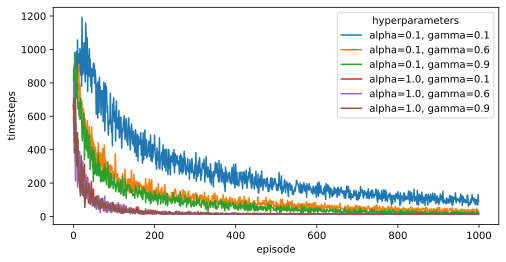

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.gcf()
fig.set_size_inches(8, 4)
sns.lineplot('episode', 'timesteps',
             hue='hyperparameters', data=results)

### averaging over several runs

In [32]:
from src.q_agent import QAgent
from src.loops import train_many_runs

alphas = [0.1, 1]
gammas = [0.1, 0.6, 0.9]

epsilon = 0.1
n_episodes = 1000
n_runs = 10

results = pd.DataFrame()
for alpha in alphas:
    for gamma in gammas:
        
        print(f'alpha: {alpha}, gamma: {gamma}')
        agent = QAgent(env, alpha, gamma)
        
        timesteps, penalties = train_many_runs(agent,
                                               env,
                                               n_episodes,
                                               epsilon,
                                               n_runs)
        
        # collect timesteps and penalties for this pair of
        # hyper-parameters (alpha, gamma)
        results_ = pd.DataFrame()
        results_['timesteps'] = timesteps
        results_['penalties'] = penalties
        results_['alpha'] = alpha
        results_['gamma'] = gamma
        results = pd.concat([results, results_])

# index -> episode
results = results.reset_index().rename(
    columns={'index': 'episode'})

results['hyperparameters'] = [
    f'alpha={a}, gamma={g}'
    for (a, g) in zip(results['alpha'], results['gamma'])]

alpha: 0.1, gamma: 0.1


100%|██████████| 1000/1000 [00:07<00:00, 125.94it/s]


alpha: 0.1, gamma: 0.6


100%|██████████| 1000/1000 [00:03<00:00, 266.95it/s]


alpha: 0.1, gamma: 0.9


100%|██████████| 1000/1000 [00:02<00:00, 342.81it/s]


alpha: 1, gamma: 0.1


100%|██████████| 1000/1000 [00:00<00:00, 1125.37it/s]


alpha: 1, gamma: 0.6


100%|██████████| 1000/1000 [00:00<00:00, 1234.92it/s]


alpha: 1, gamma: 0.9


100%|██████████| 1000/1000 [00:00<00:00, 1019.00it/s]


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


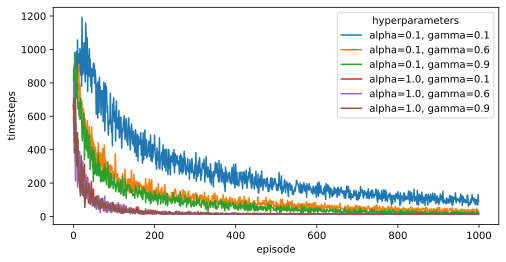

In [36]:
fig = plt.gcf()
fig.set_size_inches(8, 4)
sns.lineplot('episode', 'timesteps', hue='hyperparameters', data=results)

### best essilon ($ϵ$) value

In [38]:
# best hyper-parameters so far
alpha = 1.0
gamma = 0.9

epsilons = [0.01, 0.10, 0.9]
n_runs = 10
n_episodes = 200

results = pd.DataFrame()
for epsilon in epsilons:
        
    print(f'epsilon: {epsilon}')
    agent = QAgent(env, alpha, gamma)

    timesteps, penalties = train_many_runs(agent,
                                           env,
                                           n_episodes,
                                           epsilon,
                                           n_runs)

    # collect timesteps and penalties for this pair of
    # hyper-parameters (alpha, gamma)
    results_ = pd.DataFrame()
    results_['timesteps'] = timesteps
    results_['penalties'] = penalties
    results_['epsilon'] = epsilon
    results = pd.concat([results, results_])

# index -> episode
results = results.reset_index().rename(columns={'index': 'episode'})

epsilon: 0.01


100%|██████████| 200/200 [00:00<00:00, 342.81it/s]


epsilon: 0.1


100%|██████████| 200/200 [00:00<00:00, 374.07it/s]


epsilon: 0.9


100%|██████████| 200/200 [00:02<00:00, 72.84it/s] 


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


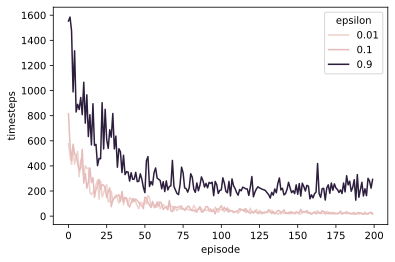

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


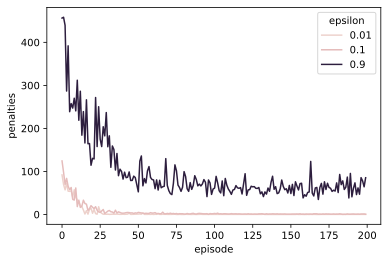

In [39]:
fig = plt.gcf()
fig.set_size_inches(6, 4)
sns.lineplot('episode', 'timesteps', hue='epsilon', data=results)
plt.show()

fig = plt.gcf()
fig.set_size_inches(6, 4)
sns.lineplot('episode', 'penalties', hue='epsilon', data=results)